In [1]:
#coding: utf-8

import warnings
# warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa
import numpy as np
import seaborn as sns
from utils import *
import matplotlib.pyplot as plt
from io import StringIO

%pylab inline

# sudo pip install librosa
# ubuntu: sudo apt-get install libav-tools
# OSX   : brew install libav OMP_NUM_THREADS=2

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [2]:
BP = "./musicdata/"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [4]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}' type=\"audio/wav\"></audio>".format(url))

In [6]:
# sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
sound_file = "./short_206377.wav"
y, sr = librosa.load(sound_file)

Audio(url=sound_file)

# Sound as 1D-Signal

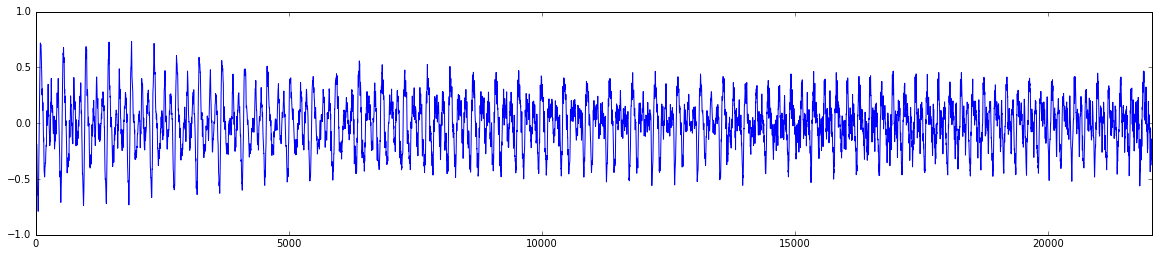

In [7]:
plt.figure(figsize=(20,4))
# 
# Используйте pylab.plot для построения графика, нарисуйте y, sr
#
pylab.plot(y)
pylab.xlim([0, sr])
pylab.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [6]:
# S = <librosa.feature.melspectrogram>
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# log_S = <librosa.logamplitude>
log_S = librosa.logamplitude(S, ref_power=np.max)

Нарисуйте спектрограмму, получилась красивая картинка?

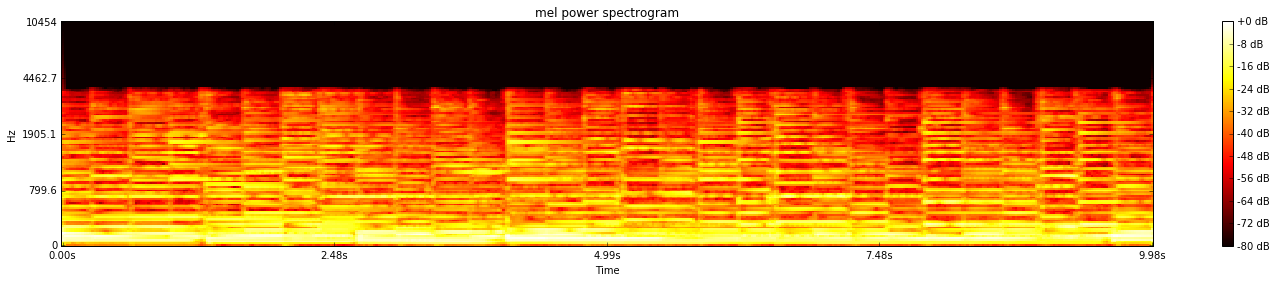

In [7]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Prepare the Data

Каждый файл с данными, это pcl (pickle) файл с numpy.array, состоящий из: 
1. WAV-файлы по строкам,
2. сэмплы по столбцам.

В этой секции мы создадим датасет, прочитав все данные.

In [4]:
X_big_val = np.load(os.path.join(BP, "spectrograms", "spectrograms%d.pcl"%7))

In [3]:
import numpy as np

X = []
for i in range(1,7):
    tmp = np.load(os.path.join(BP, "spectrograms", "spectrograms%d.pcl"%i))
    print(tmp.shape)
    X.append(tmp)

(2000, 128, 431)
(2000, 128, 431)
(2000, 128, 431)
(2000, 128, 431)
(2000, 128, 431)
(2000, 128, 431)


In [5]:
X = np.concatenate(X)

In [6]:
X.shape

(12000, 128, 431)

Здесь вы должны получить train genres. Они идут подряд в соответствии с последовательностью треков в файлах с данными. Для содержимого первых шести файлов у вас есть жанры, а для последнего файла, вам их нужно предсказать.

In [7]:
train_genres = []
with open(os.path.join(BP, "train_genres.txt"), "rt") as f_in:
    train_genres = [i.strip() for i in f_in.readlines()]
print(train_genres[:10])

['bard', 'dance', 'relax', 'rock', 'rap', 'soundtrack', 'electronics', 'pop', 'rusrap', 'pop']


In [8]:
num_classes = len(set(train_genres))
print(num_classes)

67


In [9]:
y = np.array(train_genres)
len(y)

12000

# Nearest Neighbors genre classification

Let's try to solve similarity task by the nearest neighbour approach.

<img src="./img/nn.png" width="300">

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

In [10]:
print(y.shape, X.shape)

(12000,) (12000, 128, 431)


In [11]:
perm = np.random.permutation(len(y))
X, y = X[perm], y[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [12]:
Xreshape.shape

(12000, 128, 431)

Разобьем датасет на трейн и валидацию 80/20%.

In [12]:
train_len = 10000
X_train, X_valid = Xreshape[:train_len], Xreshape[train_len:]
y_train, y_valid = y[:train_len], y[train_len:]

Попробуем поклассифицировать жанры методом ближайших соседей.

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf = clf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)
y_val_pred = clf.predict(X_valid.reshape((X_valid.shape[0], -1)))

print(accuracy_score(y_valid, y_val_pred))

0.0954166666667


# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [13]:
import theano
import lasagne
import theano.tensor as T
from utils import train_net

Using gpu device 3: GeForce GTX 680 (CNMeM is disabled, CuDNN 3007)


Перемешаем и разобьем датасет.

In [14]:
num_classes = len(list(set(y)))

In [15]:
# coding y_values:
dic_genres = {name:i for i, name in enumerate(list(set(y)))}
y_coded = [dic_genres[i] for i in y]
y = y_coded

In [16]:
y[:5]

[40, 47, 46, 43, 38]

In [15]:
perm = np.random.permutation(len(y_coded))
X, y = np.array(X)[perm].astype('float32'), np.array(y_coded)[perm].astype('int32')
Xreshape = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y_coded[:10000], y_coded[10000:]

In [18]:
input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, 1, X.shape[1], X.shape[2]), input_var=input_X) 

nn = lasagne.layers.DenseLayer(nn, num_units=1000, name='name1')
nn = lasagne.layers.DenseLayer(nn, num_units=1000, name='name2')
nn = lasagne.layers.DenseLayer(nn, num_units=1000, name='name3')

# nn = lasagne.layers.DenseLayer(nn, num_units=3000, name='name3')
nn = lasagne.layers.DenseLayer(nn, num_classes,nonlinearity=lasagne.nonlinearities.softmax)
#
# Используйте 2-3 больших полносвязных слоя, обучилась ли сеть? если нет то почему?
#

y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [18]:
lasagne.__version__

'0.2.dev1'

In [19]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [34]:
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=50)

Epoch   1 of  10 train_loss = 432.21 val_loss = 2.69 train_acc = 27.58 val_acc = 35.10
Epoch   2 of  10 train_loss = 2.69 val_loss = 2.63 train_acc = 35.02 val_acc = 35.10
Epoch   3 of  10 train_loss = 2.66 val_loss = 2.62 train_acc = 35.02 val_acc = 35.10
Epoch   4 of  10 train_loss = 2.66 val_loss = 2.62 train_acc = 35.02 val_acc = 35.10
Epoch   5 of  10 train_loss = 2.66 val_loss = 2.62 train_acc = 35.02 val_acc = 35.10
Epoch   6 of  10 train_loss = 2.66 val_loss = 2.62 train_acc = 35.02 val_acc = 35.10
Epoch   7 of  10 train_loss = 2.66 val_loss = 2.62 train_acc = 35.02 val_acc = 35.10
Epoch   8 of  10 train_loss = 2.66 val_loss = 2.62 train_acc = 35.02 val_acc = 35.10
Epoch   9 of  10 train_loss = 2.66 val_loss = 2.62 train_acc = 35.02 val_acc = 35.10
Epoch  10 of  10 train_loss = 2.66 val_loss = 2.62 train_acc = 35.02 val_acc = 35.10
CPU times: user 2min 22s, sys: 33.8 s, total: 2min 56s
Wall time: 2min 56s


# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [28]:
# import theano
# import lasagne
# import theano.tensor as T
# from utils import train_net

In [17]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

In [18]:
X_train.shape

(10000, 128, 431)

<img src="spotify_convnet.png">

In [19]:
from lasagne.layers import batch_norm

In [20]:
from lasagne.layers import get_all_layers

In [21]:
def l2fun(x, **kwargs):
    return T.mean(x ** 2, axis=2)

# ml2 = lasagne.layers.GlobalPoolLayer(nn, pool_function=l2fun)

In [22]:
from lasagne.nonlinearities import leaky_rectify, softmax

input_X, target_y = T.tensor3("X", dtype='float32'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 
# u = T.matrix('u')

# nn = ??? Сделайте свою сеть, используя: Conv1DLayer + MaxPool1DLayer + DenseLayer
nn = batch_norm(nn)
nn = lasagne.layers.Conv1DLayer(nn, num_filters=256, filter_size=4)

nn = lasagne.layers.MaxPool1DLayer(nn, pool_size=4)
nn = lasagne.layers.Conv1DLayer(nn, num_filters=256, filter_size=4)
nn = batch_norm(nn)

nn = lasagne.layers.MaxPool1DLayer(nn, pool_size=2)
n1 = lasagne.layers.Conv1DLayer(nn, num_filters=512, filter_size=4)
# n1 = lasagne.layers.get_output(nn)

nn = batch_norm(n1)

nn = lasagne.layers.MaxPool1DLayer(nn, pool_size=2)
# nn = lasagne.layers.Conv1DLayer(nn, num_filters=600, filter_size=4)

mn = lasagne.layers.GlobalPoolLayer(nn)

mx = lasagne.layers.GlobalPoolLayer(nn, pool_function=theano.tensor.max)
l2 = lasagne.layers.GlobalPoolLayer(nn, pool_function=l2fun)

nn = lasagne.layers.ConcatLayer([mn, mx, l2])


# nn = lasagne.layers.DenseLayer(nn, num_units=2048)

n2 = lasagne.layers.DenseLayer(nn, num_units=1536, nonlinearity=lasagne.nonlinearities.rectify)

n3 = lasagne.layers.DenseLayer(lasagne.layers.dropout(n2, 0.1),\
                               num_units=1536,\
                               nonlinearity=leaky_rectify,W=lasagne.init.Orthogonal())

nn = lasagne.layers.DenseLayer(n3, num_classes, nonlinearity=softmax)

In [23]:
y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn, trainable=True)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [24]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)
# predict_fun = theano.function([input_X], T.argmax(y_predicted, axis=1))

In [25]:
# Подумайте, какой размер батча нужен и сколько эпох вы можете себе позволить подождать
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=11, batch_size=50)

Epoch   1 of  11 train_loss = 2.76 val_loss = 2.48 train_acc = 34.69 val_acc = 36.80
Epoch   2 of  11 train_loss = 2.42 val_loss = 2.33 train_acc = 36.64 val_acc = 38.70
Epoch   3 of  11 train_loss = 2.30 val_loss = 2.31 train_acc = 38.24 val_acc = 38.85
Epoch   4 of  11 train_loss = 2.22 val_loss = 2.23 train_acc = 39.29 val_acc = 40.00
Epoch   5 of  11 train_loss = 2.14 val_loss = 2.18 train_acc = 40.42 val_acc = 41.00
Epoch   6 of  11 train_loss = 2.09 val_loss = 2.19 train_acc = 41.78 val_acc = 39.80
Epoch   7 of  11 train_loss = 2.03 val_loss = 2.18 train_acc = 42.23 val_acc = 40.35
Epoch   8 of  11 train_loss = 1.97 val_loss = 2.15 train_acc = 43.28 val_acc = 41.00
Epoch   9 of  11 train_loss = 1.93 val_loss = 2.15 train_acc = 44.21 val_acc = 41.10
Epoch  10 of  11 train_loss = 1.88 val_loss = 2.16 train_acc = 45.28 val_acc = 42.60
Epoch  11 of  11 train_loss = 1.82 val_loss = 2.22 train_acc = 46.17 val_acc = 42.40
CPU times: user 2min 35s, sys: 1min 7s, total: 3min 43s
Wall time

Валидационная точность должна быть около 0.6 или лучше. 

In [27]:
predict_fun = theano.function([input_X], T.argmax(y_predicted, axis=1), allow_input_downcast=True)

In [30]:
predicted = predict_fun(X_big_val)

In [31]:
len(predicted)

2000

In [48]:
dic_genres_2 = {val:key for key, val in dic_genres.items()}
dic_genres_2[2]

'conjazz'

In [46]:
with open('awesome_submission.csv', 'w') as fout:
    fout.write('Id,Category\n')
    for i, pred in enumerate(predicted):
        fout.write('{},{}\n'.format(i+12000, dic_genres_2[pred]))

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

In [86]:
lasagne.layers.get_all_params(nn, trainable=True)

[beta, gamma, W, b, W, beta, gamma, W, beta, gamma, W, b, W, b, W, b]

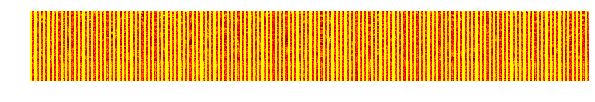

In [92]:
plt.figure(figsize=(10, 10), dpi=500)
W = lasagne.layers.get_all_params(nn, trainable=True)[2].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

Нет, боюсь, что интерпретировать это я не могу.

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [44]:
from sklearn.manifold import TSNE

In [50]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [51]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = list(map(f, X_train))+list(map(f, X_valid))
track_vectors = np.concatenate(track_vectors, axis=0)
track_labels = np.array(list(y_train) + list(y_valid))

получите 2d вектора

In [59]:
batch = 1000
output = []
for i in range(int(len(X)/batch)):
    last = i*batch
    out = get_layer_output(X[last:last+batch])
    output.append(out[0])

output = np.vstack(output)

In [60]:
def draw_layer_output(layer, output):
    
    rprt = lasagne.layers.get_output(layer)
    get_layer_output = theano.function([input_X], [rprt], allow_input_downcast=True)
    
    tsne_x = TSNE().fit_transform(output)
    
    id2gener = dic_genres_2
    plt.figure(figsize=(15,15), dpi=500)
    colors = cm.hot(np.linspace(0, 1, len(id2gener)))

    for idx, gener in id2gener.items():
        idx_ = np.where(track_labels == idx)
        pylab.scatter(tsne_x[idx_, 0], tsne_x[idx_, 1], c=colors[idx], cmap=cm.hot, label=gener,s=50)

    pylab.legend(loc=0, ncol=5)

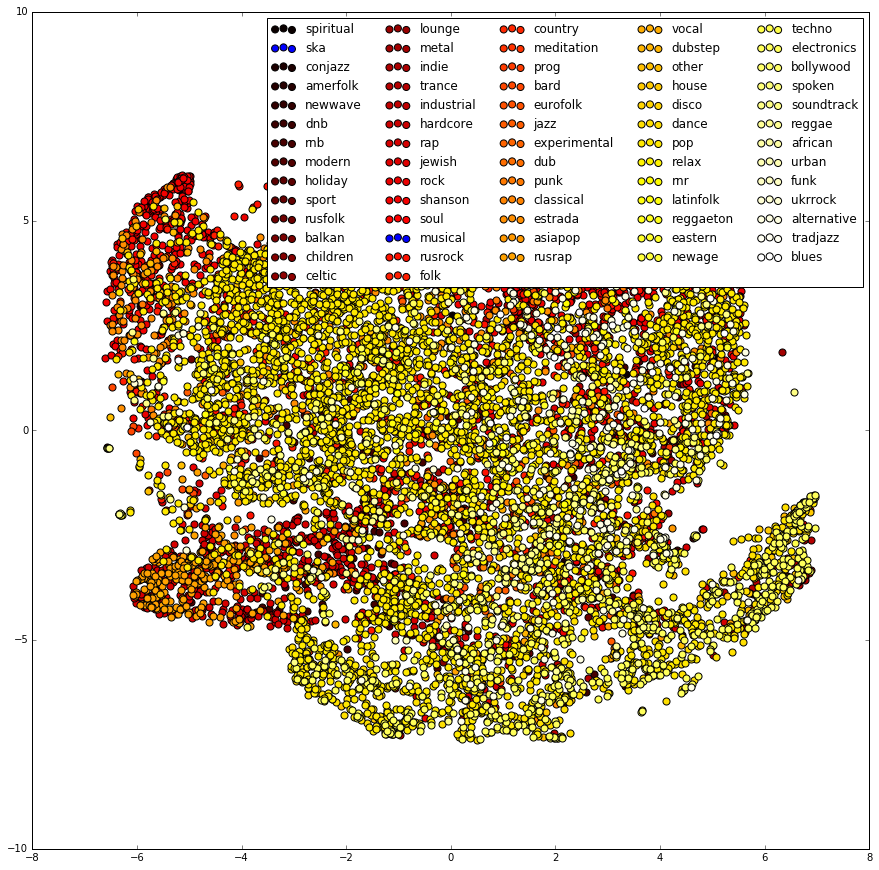

In [61]:
### Output of dense layer 3 ###

draw_layer_output(n3, output)

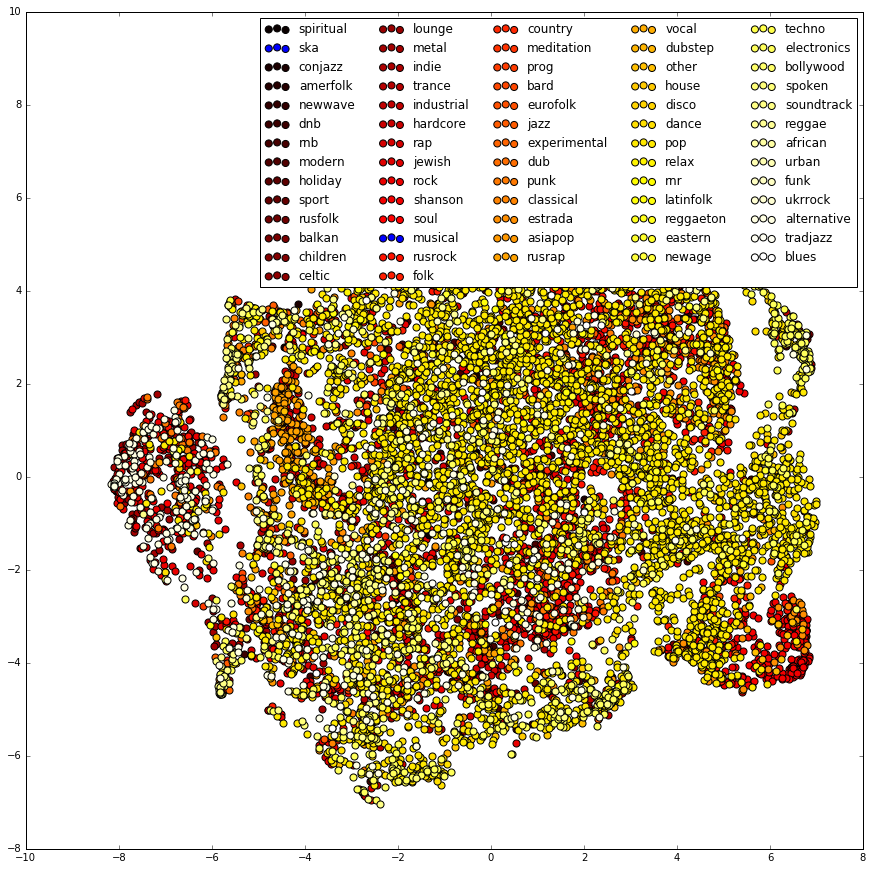

In [62]:
### Output of dense layer 2 ###

draw_layer_output(n2, output)

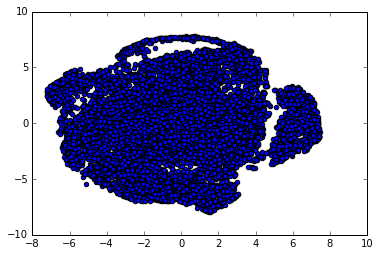

In [56]:
plt.scatter(tsne_x[:,1], tsne_x[:,0])